In [49]:
# !pip install --quiet librosa datasets[audio]
# !pip install --quiet gradio
# !pip install --quiet transformers
!pip install torch

  Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.7.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Usi

In [1]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name = "en-AU", split = "train")
minds

/home/multi-lap-49/Documents/trash/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [2]:
example = minds[0]
example

{'path': '/home/multi-lap-49/.cache/huggingface/datasets/downloads/extracted/064d28989f1e4aad3cbc1534526f1d2d28baac8e282714313ef6cac2aef242e0/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/multi-lap-49/.cache/huggingface/datasets/downloads/extracted/064d28989f1e4aad3cbc1534526f1d2d28baac8e282714313ef6cac2aef242e0/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ], shape=(62415,)),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [3]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [4]:
columns_to_remove = ["lang_id","english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [15]:
import gradio as gr
def generate_audio():
    example  = minds.shuffle()[0]
    audio = example["audio"]
    return(audio["sampling_rate"], audio["array"]), id2label(example["intent_class"])

with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio , label = generate_audio()
            output = gr.Audio(audio, label =label)
        
demo.launch(debug=True)

/home/multi-lap-49/Documents/trash/.conda/lib/python3.11/site-packages/gradio/processing_utils.py:749: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


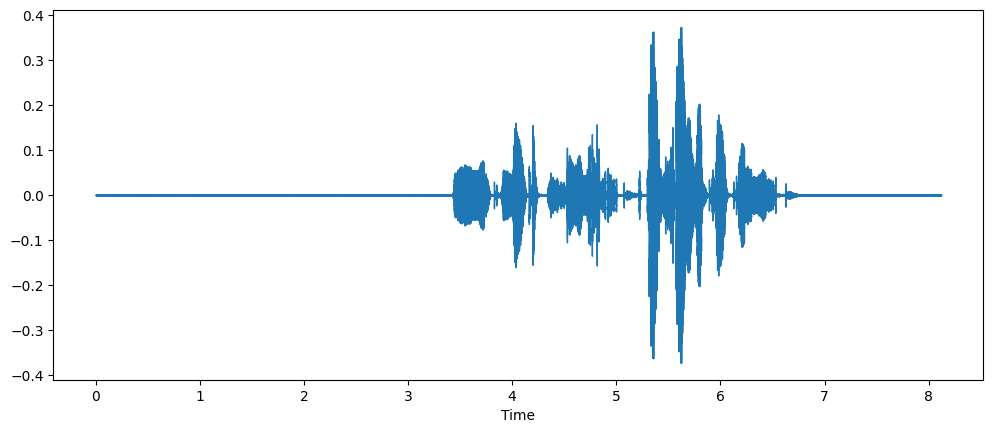

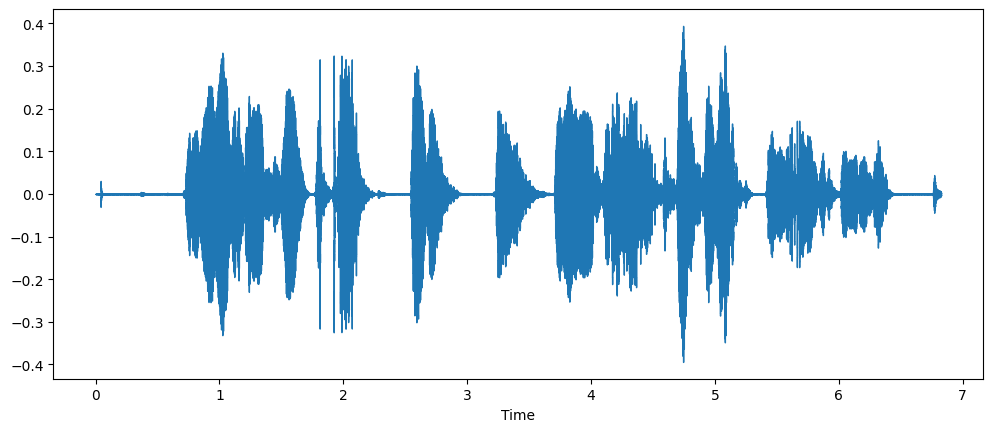

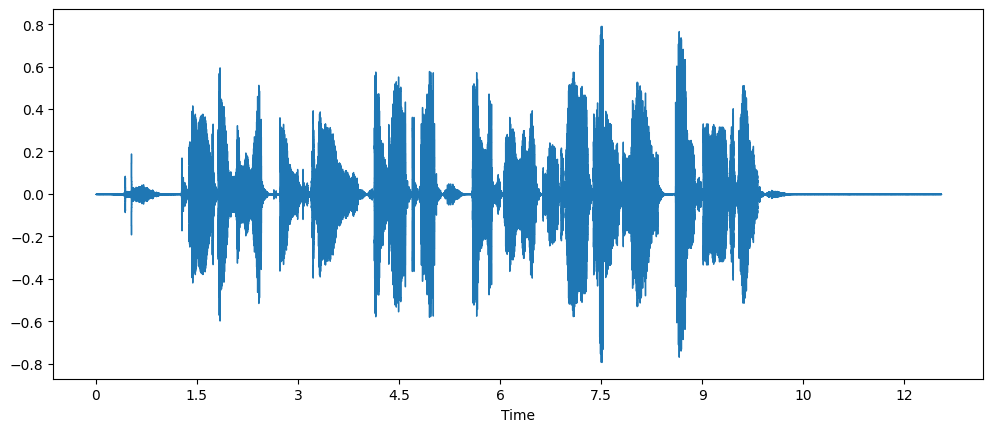

In [14]:
import librosa
import matplotlib.pyplot as plt
for i in range(3):
    example = minds.shuffle()[0]

    array, sampling_rate = example["audio"]["array"], example["audio"]["sampling_rate"]
    plt.figure().set_figwidth(12)
    librosa.display.waveshow(array,sr = sampling_rate)

In [35]:
from datasets import Audio
minds = minds.cast_column("audio", Audio(sampling_rate=16000))
minds[0]

{'path': '/home/multi-lap-49/.cache/huggingface/datasets/downloads/extracted/064d28989f1e4aad3cbc1534526f1d2d28baac8e282714313ef6cac2aef242e0/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/multi-lap-49/.cache/huggingface/datasets/downloads/extracted/064d28989f1e4aad3cbc1534526f1d2d28baac8e282714313ef6cac2aef242e0/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04], shape=(124830,)),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

##Filtering

In [40]:
MAX_LENGTH_IN_SECONDS = 20
def filter_audio(length):
    return length<=MAX_LENGTH_IN_SECONDS

In [41]:
new_columns = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_columns)

minds = minds.filter(filter_audio, input_columns=["duration"])
minds = minds.remove_columns(["duration"])  
minds

Filter: 100%|██████████| 654/654 [00:00<00:00, 51976.78 examples/s]


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

In [42]:
minds[0]

{'path': '/home/multi-lap-49/.cache/huggingface/datasets/downloads/extracted/064d28989f1e4aad3cbc1534526f1d2d28baac8e282714313ef6cac2aef242e0/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/multi-lap-49/.cache/huggingface/datasets/downloads/extracted/064d28989f1e4aad3cbc1534526f1d2d28baac8e282714313ef6cac2aef242e0/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04], shape=(124830,)),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

Preprocessing audio data


In [50]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained('openai/whisper-small')

In [53]:
def prepare_dataset(example):
    audio_sample = example['audio']
    features  = feature_extractor(audio_sample["array"],sampling_rate=audio_sample["sampling_rate"], padding = True)
    return features

In [54]:
minds = minds.map(prepare_dataset)
minds

Map: 100%|██████████| 624/624 [03:05<00:00,  3.37 examples/s]


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

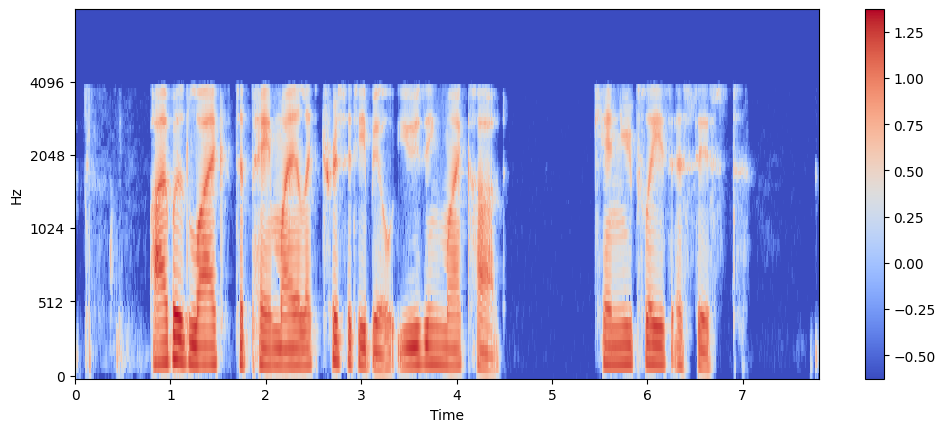

In [56]:
import numpy as np
example = minds[0]
input_features = example["input_features"]
plt.figure().set_figwidth(12)
librosa.display.specshow(np.asarray(input_features[0]),sr = feature_extractor.sampling_rate, x_axis="time",y_axis = "mel", hop_length=feature_extractor.hop_length)
plt.colorbar()
